**Draft Model for Mice Steep Stage Analysis**

In [1]:
import torch
import torch.nn.functional as F
from torch import optim, nn
from torchvision import transforms, datasets, models


import torch.utils.data as utils
from sklearn.metrics import accuracy_score
from inputMassager import *


In [2]:
inputHandler = inputMassager()
data_filepath = inputHandler.askForInput("Blah!")
annotated_filepath = inputHandler.askForInput("Blah!")
period_size = 200
num_periods =  60000
labels, eeg_samples, emg_samples, eeg_fft, emg_fft = get_labeled_data(data_filepath, annotated_filepath, period_size, num_periods)

/Users/audreyostrom/CSE144/mice-sleep-analysis/inputMassager.py:285: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:276.)
  fft_tensor[index, 0] = torch.fft.fft(torch.tensor(row[col]))


In [3]:
everything = torch.cat((eeg_samples, eeg_fft), dim = 1)
print(everything.size())

torch.Size([60000, 2, 200])


In [4]:
#ds = torch.utils.data.TensorDataset(eeg_fft, emg_fft, labels)
ds = torch.utils.data.TensorDataset(eeg_samples, torch.tensor(labels))

train_size = int(len(ds) *.80)
val_size = len(ds) - int(len(ds) *.80)

train_dataset, val_dataset = torch.utils.data.random_split(ds, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Creating class for Model**

In [6]:
class CNN(nn.Module):
    def __init__(self, period_size, input_channels=1):
        super(CNN, self).__init__()
        self.input_channels = input_channels
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=period_size, kernel_size=period_size//2)
        self.conv2 = nn.Conv1d(in_channels=period_size, out_channels=period_size//4, kernel_size=8)
        self.conv3 = nn.Conv1d(in_channels=period_size//4, out_channels=256, kernel_size=2)


        # out_channels and kernal size are random
        self.fc1 = nn.Linear(2560, 20) # 10 is random
        self.fc2 = nn.Linear(10, 5)


    def forward(self, x, verbose=False):
        #print(x.size())
        x = self.conv1(x)
        x = F.relu(x)
        # print(x.size())
        x = F.max_pool1d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.max_pool1d(x, kernel_size=2)
        # print(x.size())
        x = self.conv3(x)
        x = F.max_pool1d(x, kernel_size=2)
        #print(x.size())
        x = x.flatten(1)
        #print(x.size())
        x = self.fc1(x)
        x = F.max_pool1d(x, kernel_size=2)
        # print(x.size())
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [17]:
def train_model(model, dataloader):
    print("device:", device)
    model.to(device)
    model.train() # set model to training mode

  
    # class_weights = torch.tensor([1/50, 1/5886, 1/13258, 1/285, 0], device=device)
    class_weights = torch.tensor([0.9, 2.6, 0.7, 0.5, 0.9], device=device)

    loss_fun = nn.CrossEntropyLoss(weight=class_weights) #define a loss function object
    for batch_idx, (channel1, channel2, target) in enumerate(dataloader):
        channel1, channel2, target = channel1.to(device), channel2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(channel1, channel2) # guess we have to pass all channels instead of data?
        pred_value, pred = output.data.max(1, keepdim=True) # get the index of the max log-probability   
        model.to(device)

        loss = loss_fun(output,target)
        loss.backward()
        optimizer.step()
    return accuracy_score(target.tolist(), pred), loss.item()
    

In [18]:
model = CNN(period_size)
model.to(device)
  
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.9)

In [22]:
def evaluate_model(model, dataloader, is_test=False, confidence_level = -0.5):
  # Set model to evaluation mode
  model.eval()

  #dictionary to store the accuracy of predictions by sleep stage
  acurracy_stages = {0:[], 1:[], 2:[], 3:[], 4:[]}
  stage_names = ["not sure(0): ", "rem accuracy(1): ", "non-rem accuracy(2): ", "wake accuracy(3): ", "artifact accuracy(4): "]
  predictions = []
  label_list = []
  

  with torch.no_grad():
    correct = 0
    loss = 0

    criterion = torch.nn.CrossEntropyLoss(reduction='none')

    for channel1, channel2, target in dataloader:
        channel1, channel2, target = channel1.to(device), channel2.to(device), target.to(device)
        outputs = model(channel1, channel2)

        loss += torch.sum(criterion(outputs, target)).item()

        pred_value, pred = outputs.data.max(1, keepdim=True) # get the index of the max log-probability                                           
          
        for i in range(len(target)): 
           if 4 in target[i]:
             target[i] = 4
             pred[i] = 4
          
          #if the predicted value is lower that the confidence level, set the predicted value to 0 and the target value to 0
           if pred_value[i] < confidence_level:
            pred[i] = 4
            target[i] = 4

          #append boolean indicating whether or not each prediction matched the target to the apporpriate sleep stage list
           acurracy_stages[target[i].item()].append(pred[i].eq(target[i]).item())
           predictions.append(pred[i].item())
           label_list.append(target[i].item())

           
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

          

#calculate total accuracy and loss
    loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        "Test" if is_test else "Validation",
        loss, correct, len(dataloader.dataset),
        accuracy))
    

  # Set model back to training mode
  model.train()
  return predictions, label_list, loss

In [26]:
import matplotlib.pyplot as plt
def train_and_test(model, train_data_gen, test_data_gen, max_epochs, confidence_level=-0.75, is_test=False, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        accuracy_train, loss_train = train_model(model, train_data_gen)
        history_train['acc'].append(accuracy_train)
        history_train['loss'].append(loss_train)


        # Do the same for the testing loop
        predictions, label_list, test_loss = evaluate_model(model, test_data_gen, is_test=False, confidence_level=confidence_level)
        history_test['acc'].append(accuracy_score(label_list, predictions))
        history_test['loss'].append(test_loss)


        """fix this calculation"""

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return predictions, label_list

device: cpu

Validation set: Average loss: 0.4624, Accuracy: 11128/12000 (93%)

[Epoch 1/2] acc: 0.86% - test_acc: 0.93%
device: cpu

Validation set: Average loss: 0.4337, Accuracy: 11116/12000 (93%)

[Epoch 2/2] acc: 0.96% - test_acc: 0.93%


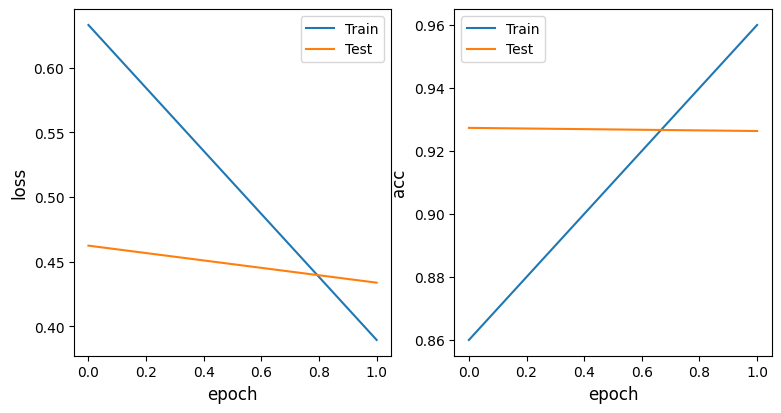

Testing Report for Dual CNN with Fourier Transform for Accuracy, Precision, Recall, and F1-Score
------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         REM       0.00      0.00      0.00       468
     Non-REM       0.94      0.95      0.94      3588
        Wake       0.92      0.97      0.94      7600
    Artifact       1.00      1.00      1.00       344

    accuracy                           0.93     12000
   macro avg       0.71      0.73      0.72     12000
weighted avg       0.89      0.93      0.91     12000

Classified Periods:
Class 3, Wake: 8023
Class 2, Non-REM: 3626
Class 4, Artifact: 344
Class 1, REM: 7


In [27]:
#if you make the confidence level too low, you'll get an error about not being able to divede by 0,
#that just means that none of the data is being classified to not sure, keep it below -.75 to avoid this
from sklearn.metrics import classification_report
predictions, label_list = train_and_test(model, train_loader, val_loader, 2, confidence_level=-0.75, is_test=False, verbose=True)

target_names = ['REM', 'Non-REM', 'Wake', 'Artifact']
print('Testing Report for Dual CNN with Fourier Transform for Accuracy, Precision, Recall, and F1-Score')
print('------------------------------------------------------------------------------------------------')
print(classification_report(label_list, predictions, labels=[1,2,3,4], target_names=target_names))



# Calculate class-wise counts
predictions_df = pd.Series(predictions, name='Predicted')
counts = predictions_df.value_counts()

print('Classified Periods:')
for class_name, count in counts.items():
    print(f"Class {class_name}, {target_names[class_name-1]}: {count}")

In [ ]:
print(len(predictions))

with more training data, the model almost always predicts wake becuase it's so overepresented, when i was running just 10000 periods, it was in the mid to low 90s for non-rem and rem accuracy but with all the data, it's 99% accurate for wake and in the 30s for non rem